In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
%matplotlib inline

In [21]:
# original_df = pd.read_csv('./data/driving_log.csv')
# recorded_df = pd.read_csv('./data/recorded_driving_log.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'])

# column_names = ['center', 'left', 'right']
# for col in column_names:
#     new = recorded_df[col].str.split('av-behavioral-cloning/', n=2, expand=True)
#     recorded_df[col] = new[1]

# combined_df = original_df.append(recorded_df, ignore_index=True)

In [24]:
# combined_df.to_csv('driving_log.csv', index=False)

In [2]:
df = pd.read_csv('./data/driving_log.csv')

steering_offset = [0., 0.2, -0.2]
camera = ['center', 'left', 'right']
full_df = pd.DataFrame()
for i in range(3):
    temp_df = df[[camera[i], 'steering']].copy()
    temp_df['steering'] = temp_df['steering'] + steering_offset[i]
    temp_df.rename(columns = {camera[i]:'filename'}, inplace = True)
    full_df = full_df.append(temp_df, ignore_index=True, sort=False)
full_df['filename'] = full_df['filename'].str.lstrip()

In [3]:
full_df

,filename,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,0.0
...,...,...
41605,IMG/right_2020_04_08_02_57_56_526.jpg,-0.2
41606,IMG/right_2020_04_08_02_57_56_593.jpg,-0.2
41607,IMG/right_2020_04_08_02_57_56_660.jpg,-0.2
41608,IMG/right_2020_04_08_02_57_56_729.jpg,-0.2


In [3]:
X = full_df['filename'].values
y = full_df['steering'].values 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=32, shuffle=True)

In [10]:
def parse_function(filename, steer_angle):
    image_string = tf.io.read_file('./data/' + filename)
    image = tf.io.decode_jpeg(image_string, channels=3)
    return image, steer_angle

def train_preprocess(image, steer_angle):
    processed_image = image[55:-20]
    processed_image = tf.image.resize(processed_image, [66, 200], method='bilinear')
    if np.random.rand() < .5: # Randomly perform horizontal flip
        processed_image = tf.image.flip_left_right(processed_image)
        steer_angle = -steer_angle
    processed_image = processed_image / 255            
    processed_image = tf.image.rgb_to_yuv(processed_image)  # y -> [0, 1], u & v -> [-0.5, 0.5]
    processed_image = (processed_image - [0.5, 0., 0.]) * 2 # normalize all channels to [-1, 1]
#     processed_image = tf.image.per_image_standardization(processed_image)
    return processed_image, steer_angle            

In [11]:
def preprocess(image):
    processed_image = tf.expand_dims(tf.dtypes.cast(image[55:-20], tf.float32), 0)
    processed_image = tf.image.resize(processed_image, [66, 200], method='bilinear')
    processed_image = processed_image / 255            
    processed_image = tf.image.rgb_to_yuv(processed_image)
    processed_image = (processed_image - [0.5, 0., 0.]) * 2 # normalize all channels to [-1, 1]
#     processed_image = tf.image.per_image_standardization(processed_image)
    return processed_image            

In [12]:
def dataloader(X, y, batch_size=32):
    return tf.data.Dataset.from_tensor_slices((X, y)) \
                          .shuffle(len(X))            \
                          .map(parse_function)        \
                          .map(train_preprocess)      \
                          .batch(batch_size)          \
                          .prefetch(1)

In [13]:
PilotNet = models.Sequential([
            # Three Convolution Layers: 5x5, strides = 2
            layers.Conv2D(24, (5, 5), strides=(2,2), activation='relu', input_shape=(66,200,3)),
            layers.Conv2D(36, (5, 5), strides=(2,2), activation='relu'),
            layers.Conv2D(48, (5, 5), strides=(2,2), activation='relu'),
            # Two Convolution Layers: 3x3, strides = 1
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Conv2D(64, (3, 3), activation='relu'),
            # Flatten Layer (output=1152)
            layers.Flatten(),
            # Three Fully-connected Layers with Dropout(0.5)
            layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
            layers.Dropout(0.5),
            layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
            layers.Dropout(0.5),
            layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
            layers.Dropout(0.5),
            layers.Dense(1)
        ])

PilotNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [14]:
train_dataloader = dataloader(X_train, y_train)
valid_dataloader = dataloader(X_valid, y_valid)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=0.00003)
PilotNet.compile(loss="mean_squared_error", optimizer=optim, metrics=["mse"])

In [19]:
history = PilotNet.fit(train_dataloader, epochs=50, validation_data=valid_dataloader, callbacks=[early_stopping_cb])

Train for 1171 steps, validate for 131 steps
Epoch 1/50
1171/1171 [==============================] - 31s 27ms/step - loss: 0.0209 - mse: 0.0202 - val_loss: 0.0743 - val_mse: 0.0737
Epoch 2/50
1171/1171 [==============================] - 31s 26ms/step - loss: 0.0208 - mse: 0.0201 - val_loss: 0.0705 - val_mse: 0.0700
Epoch 3/50
1171/1171 [==============================] - 31s 26ms/step - loss: 0.0205 - mse: 0.0198 - val_loss: 0.0707 - val_mse: 0.0705
Epoch 4/50
1171/1171 [==============================] - 31s 26ms/step - loss: 0.0208 - mse: 0.0200 - val_loss: 0.0715 - val_mse: 0.0713
Epoch 5/50
1171/1171 [==============================] - 31s 26ms/step - loss: 0.0205 - mse: 0.0197 - val_loss: 0.0701 - val_mse: 0.0698
Epoch 6/50
1171/1171 [==============================] - 31s 26ms/step - loss: 0.0206 - mse: 0.0199 - val_loss: 0.0739 - val_mse: 0.0737
Epoch 7/50
1171/1171 [==============================] - 31s 26ms/step - loss: 0.0205 - mse: 0.0198 - val_loss: 0.0739 - val_mse: 0.0727
Epo

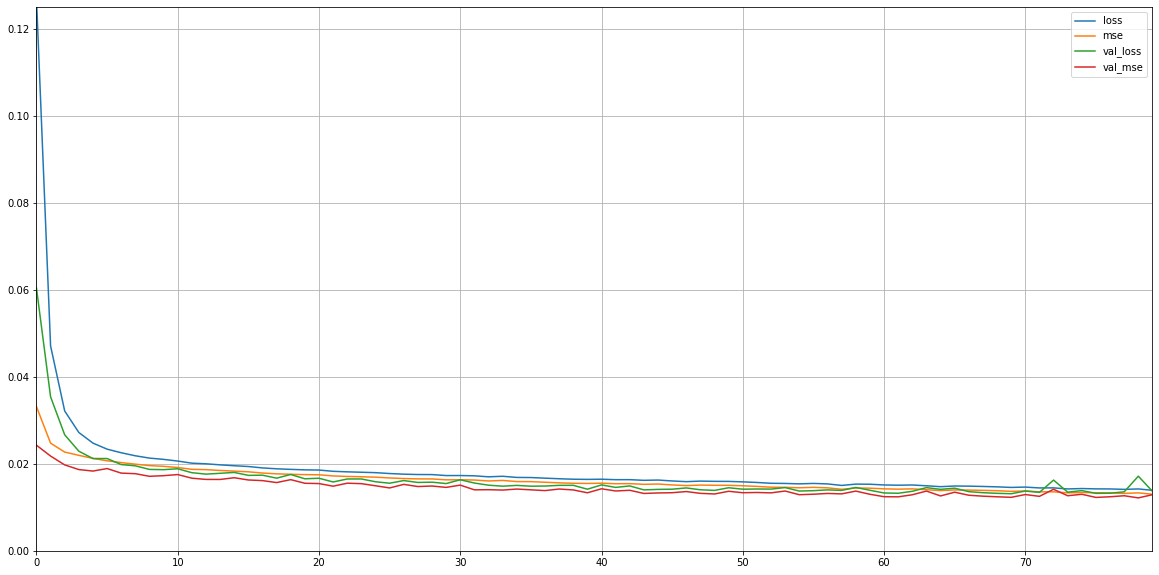

In [55]:
# df = pd.DataFrame(history.history)
# df = df.append(pd.DataFrame(history.history), ignore_index=True)
df.plot(figsize=(20,10))
plt.grid(True)
plt.gca().set_ylim(0, 0.125)
plt.show()

In [17]:
PilotNet.save("model.h5")
# PilotNet = models.load_model("model.h5")

predict: -0.0031035314314067364 | target: 0.11175974000000001


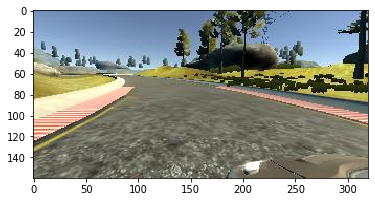

In [21]:
idx = np.random.randint(0, len(X_valid), 1)[0]
img = cv2.imread('./data/' + X_valid[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
pred = PilotNet.predict(preprocess(img), batch_size=1)
target = y_valid[idx]
print(f'predict: {float(pred)} | target: {target}')

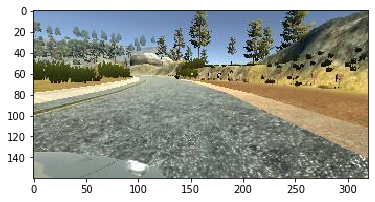

In [30]:
idx = np.random.randint(0, len(X_valid), 1)[0]
image = cv2.imread('./data/' + X_valid[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# img = preprocess(img) 
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: Floating point image RGB values must be in the 0..1 range.

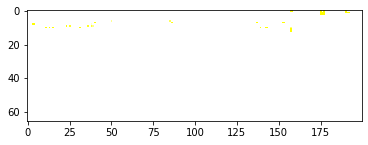

In [31]:
image_string = tf.io.read_file('./data/' + filename)
image = tf.io.decode_jpeg(image_string, channels=3)
processed_image = image[55:-20]
processed_image = tf.image.resize(processed_image, [66, 200], method='bilinear')
plt.imshow(processed_image.numpy())
plt.imsave("crop_and_resize.png", processed_image.numpy())
#     if np.random.rand() < .5: # Randomly perform horizontal flip
#         processed_image = tf.image.flip_left_right(processed_image)
#         steer_angle = -steer_angle
#     processed_image = processed_image / 255            
#     processed_image = tf.image.rgb_to_yuv(processed_image)  # y -> [0, 1], u & v -> [-0.5, 0.5]
#     processed_image = (processed_image - [0.5, 0., 0.]) * 2 # normalize all channels to [-1, 1]